In [1]:
pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BartTokenizer, BartForConditionalGeneration

# load dateset
data = pd.read_excel('dis dataset(3).xlsx')

# data pre-processing
tfidf_vectorizer = TfidfVectorizer(max_features=1500)
tfidf_features = tfidf_vectorizer.fit_transform(data['Symptom']).toarray()

model = SentenceTransformer('all-MiniLM-L6-v2')
bert_embeddings = model.encode(data['Symptom'].tolist())

# combination feature
features = np.hstack((tfidf_features, bert_embeddings))

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features)
data['Cluster'] = clusters

# anomaly detection
iso_forest = IsolationForest(random_state=42)
anomalies = iso_forest.fit_predict(features)
data['Anomaly'] = anomalies == -1

# Load BART model and word divider
bart_model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
bart_tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

# Similarity search function (Look for the 5 most relevant diseases)
def find_similar_symptoms(input_symptom, n_results=5):
    input_embedding = model.encode([input_symptom])[0]
    input_feature = np.hstack((tfidf_vectorizer.transform([input_symptom]).toarray()[0], input_embedding))
    similarity_scores = cosine_similarity([input_feature], features)[0]
    top_indexes = np.argsort(similarity_scores)[-n_results:]
    return data.iloc[top_indexes][['Symptom', 'Disease name', 'Cluster', 'Anomaly', 'Treatment recommendation']], similarity_scores[top_indexes]

# User input symptom
query_symptom = input("Please enter a description of your symptoms:")
similar_symptoms, similarity_scores = find_similar_symptoms(query_symptom)

# Output similar symptoms and diseases and their similarity
print("Five diseases with symptoms similar to those you describe and how similar they are：")
print(similar_symptoms[['Disease name']])
print("Similarity scores ranked from low to high:", similarity_scores)

# Output the most similar symptoms and diseases
highest_similarity_index = np.argmax(similarity_scores)
highest_similarity_symptom = similar_symptoms.iloc[highest_similarity_index]
highest_similarity_score = similarity_scores[highest_similarity_index]
highest_similarity_score_percent = highest_similarity_score * 100  # 转换为百分比
print('The disease most similar to the one you described and its probability:', highest_similarity_symptom['Disease name'], f'{highest_similarity_score_percent:.2f}%')

# Summarize treatment recommendations for diseases with the highest similarity
treatment_text = highest_similarity_symptom['Treatment recommendation']

# segment handling
paragraphs = treatment_text.split("\n")
input_text = ""
output_text = ""
for paragraph in paragraphs:
    if len(input_text) + len(paragraph) < 1024:
        input_text += paragraph + "\n"
    else:
        print("The unsummarized sentence is:", input_text)
        inputs = bart_tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)
        summary_ids = bart_model.generate(inputs['input_ids'], num_beams=5, early_stopping=True)
        output_text += bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True) + "\n"
        input_text = paragraph + "\n"

if input_text:
    print("The unsummarized sentence is:", input_text)  # Process the remaining paragraphs
    inputs = bart_tokenizer(input_text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = bart_model.generate(inputs['input_ids'], num_beams=7, early_stopping=True)
    output_text += bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Summary of treatment recommendations:", output_text)

print("\nData clustering and anomaly detection results:")
print(data[['Disease name', 'Cluster', 'Anomaly']])


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Please enter a description of your symptoms:I don't feel well and can't go to work or do normal activities. I have a slight fever. I have been coughing with a sore throat and a runny nose. I'm not hungry and I can't eat any food. I seem to have lost my sense of taste and eat without taste.
Five diseases with symptoms similar to those you describe and how similar they are：
               Disease name
124                     Flu
144               Hay fever
56                  Catarrh
282             Sore throat
82   Coronavirus (COVID-19)
Similarity scores ranked from low to high: [0.31844361 0.32004693 0.33191397 0.36058827 0.4888533 ]
The disease most similar to the one you described and its probability: Coronavirus (COVID-19) 48.89%
The unsummarized sentence is: drink fluids like water to keep yourself hydrated
get plenty of rest
wear loose, comfortable clothing – don’t try to make yourself too cold
take over-the-counter medications like paracetamol – always follow the manufacturer’s 

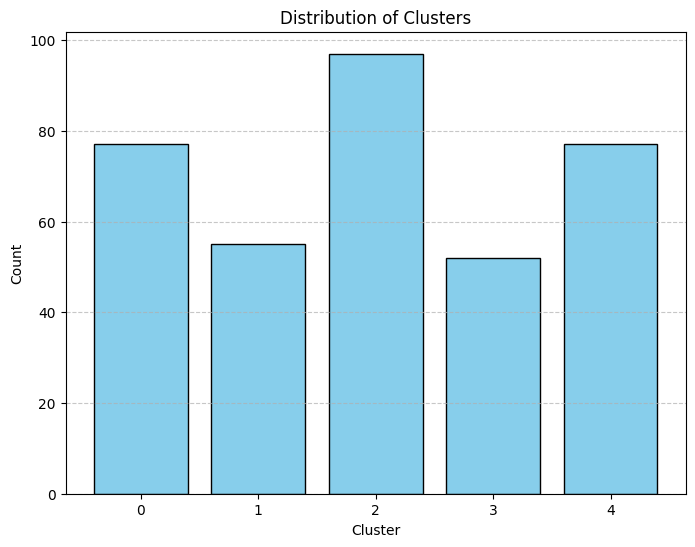

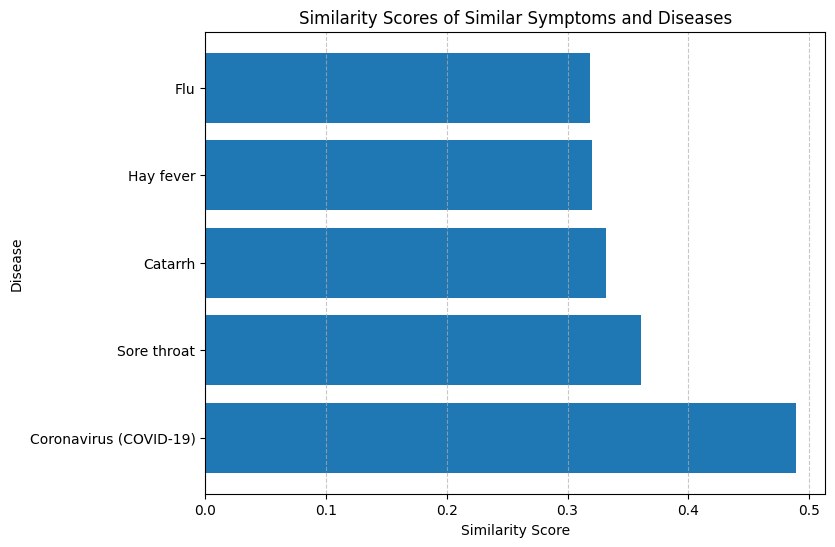

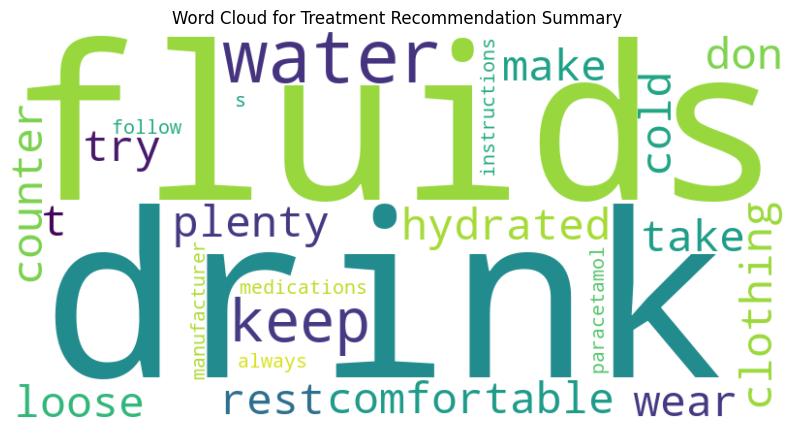

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))
plt.hist(data['Cluster'], bins=range(6), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.xticks(range(5))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



plt.figure(figsize=(8, 6))
plt.barh(similar_symptoms['Disease name'], similarity_scores)
plt.xlabel('Similarity Score')
plt.ylabel('Disease')
plt.title('Similarity Scores of Similar Symptoms and Diseases')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

from wordcloud import WordCloud


wordcloud = WordCloud(width=800, height=400, background_color='white').generate(output_text)


plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Treatment Recommendation Summary')
plt.axis('off')
plt.show()

